# Launch implementation

In [7]:
try:
    import dotenv
except ImportError:
    !pip install python-dotenv

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv('.env')

PATH_TO_DATA_ROOT_TRAIN = os.getenv("PATH_TO_DATA_ROOT_TRAIN", "/kaggle/input/human-faces2anime-faces/train/train")
PATH_TO_DATA_ROOT_VAL   = os.getenv("PATH_TO_DATA_ROOT_VAL", "/kaggle/input/human-faces2anime-faces/val/val")
PATH_TO_CHECKPOINT      = os.getenv("PATH_TO_CHECKPOINT") # after train you will have checkpoints
WORKING_IMAGE_SIZE      = int(os.getenv("WORKING_IMAGE_SIZE", 256))
BATCH_SIZE              = int(os.getenv("BATCH_SIZE", 1))
BETAS1                  = float(os.getenv("BETAS1", 0.5))
BETAS2                  = float(os.getenv("BETAS2", 0.999))
LEARNING_RATE           = float(os.getenv("LEARNING_RATE", 2e-4))
BETAS                   = (BETAS1, BETAS2)
L1_LAMBDA               = int(os.getenv("L1_LAMBDA", 100))
CYCLE_LAMBDA            = int(os.getenv("CYCLE_LAMBDA", 10))
IDENTITY_LAMBDA         = int(os.getenv("IDENTITY_LAMBDA", 0))
WANDB_TOKEN = "" # use your token
PATH_TO_CHECKPOINT = ""

In [9]:
PATH_TO_DATA_ROOT_TRAIN, PATH_TO_DATA_ROOT_VAL 

('/kaggle/input/human-faces2anime-faces/train/train',
 '/kaggle/input/human-faces2anime-faces/val/val')

In [10]:
!rm -r /kaggle/working/pytorch-anime-style-transfer
!git clone https://github.com/ThViviani/pytorch-anime-style-transfer.git

import sys
import os

sys.path.append('/kaggle/working/pytorch-anime-style-transfer')
os.chdir('pytorch-anime-style-transfer/')

rm: cannot remove '/kaggle/working/pytorch-anime-style-transfer': No such file or directory
Cloning into 'pytorch-anime-style-transfer'...
remote: Enumerating objects: 456, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 456 (delta 125), reused 149 (delta 73), pack-reused 234 (from 1)
Receiving objects: 100% (456/456), 10.58 MiB | 19.25 MiB/s, done.
Resolving deltas: 100% (293/293), done.


In [11]:
!pip install -r requirements.txt

Obtaining file:///kaggle/working/pytorch-anime-style-transfer (from -r requirements.txt (line 2))
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 862.3 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 4.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 27.7 MB/s eta 0:00:0000:0100:01
  Running setup.py develop for pytorch-anime-style-transfer
  Attempting uninstall: pillow
    Found existing installation: pillow 10.3.0
    Uninstalling pillow-10.3.0:
      Successfully uninstalled pillow-10.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.


In [12]:
!pip install torch-fidelity
!pip install torchmetrics[image]

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import lightning as L

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Data loading

(1024, 1024, 3)


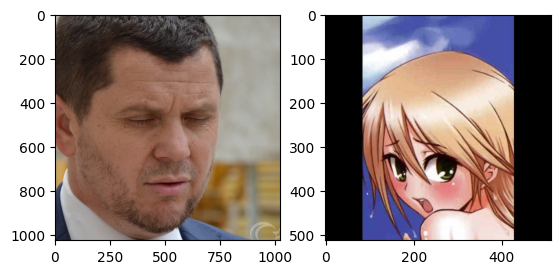

In [19]:
faces = os.listdir(PATH_TO_DATA_ROOT_TRAIN + '/human_faces')
anime_faces = os.listdir(PATH_TO_DATA_ROOT_TRAIN + '/anime_faces')

img_file_faces = faces[1]
face_img_path = os.path.join(PATH_TO_DATA_ROOT_TRAIN + '/human_faces', img_file_faces)
face_img = np.array(Image.open(face_img_path))
print(face_img.shape)

img_file_anime_faces = anime_faces[1]
anime_faces_img_path = os.path.join(PATH_TO_DATA_ROOT_TRAIN + '/anime_faces', img_file_anime_faces)
anime_face_img = np.array(Image.open(anime_faces_img_path))

fig, ax = plt.subplots(1, 2)
ax[0].imshow(face_img)
ax[1].imshow(anime_face_img)

In [20]:
class UnpairedDataset(Dataset):
    def __init__(self, root_X, root_Y):
        self.root_X = root_X
        self.root_Y = root_Y

        self.X_images = os.listdir(root_X)
        self.Y_images = os.listdir(root_Y)

        self.length_dataset = min(len(self.X_images), len(self.Y_images))
        self.X_len          = len(self.X_images)
        self.Y_len          = len(self.Y_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        X_file = self.X_images[index % self.length_dataset]
        Y_file = self.Y_images[index % self.length_dataset]

        x_path = os.path.join(self.root_X, X_file)
        y_path = os.path.join(self.root_Y, Y_file)

        x_img = Image.open(x_path)
        y_img = Image.open(y_path)

        transform = transforms.Compose([
            transforms.Resize((WORKING_IMAGE_SIZE, WORKING_IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

        x_img = transform(x_img)
        y_img = transform(y_img)

        return x_img, y_img

In [21]:
train_dataset = UnpairedDataset(
    PATH_TO_DATA_ROOT_TRAIN + '/human_faces',
    PATH_TO_DATA_ROOT_TRAIN + '/anime_faces',
)

val_dataset = UnpairedDataset(
    PATH_TO_DATA_ROOT_VAL + '/human_faces',
    PATH_TO_DATA_ROOT_VAL + '/anime_faces',
)

len(train_dataset), len(val_dataset)

(2514, 629)

In [22]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset

class MyDataModule(L.LightningDataModule):
    def __init__(self, train_dataset, val_dataset, batch_size):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset 
        self.batch_size = batch_size

    def setup(self, stage=None):
        pass
        # subset_indices = list(range(10))
        # self.train_dataset = Subset(self.train_dataset, subset_indices)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [23]:
data_module = MyDataModule(train_dataset, val_dataset, BATCH_SIZE)

In [24]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2)

In [25]:
len(train_loader), len(val_loader)

(2514, 629)

# Model fitting

In [14]:
from src.data import utils
from src.models.cycle_gan import *
from src.models.options import TrainOptions


# cycle_gan = CycleGAN.load_from_checkpoint(
#     PATH_TO_CHECKPOINT,
#     map_location=torch.device('cpu')
# )

cycle_gan = CycleGAN()

## Visualize experiments and training process

In [ ]:
import wandb

wandb.login(key=WANDB_TOKEN)

In [ ]:
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import LearningRateMonitor

wandb_logger = WandbLogger(
    project='My cycle-gan implementation', 
    save_dir='',
    log_model=True
) 

lr_monitor_cb = LearningRateMonitor(logging_interval='epoch')
trainer = L.Trainer(
    max_epochs=200, 
    logger=wandb_logger, 
    callbacks=[lr_monitor_cb], 
    precision="16-mixed"
)

trainer.fit(model=cycle_gan, datamodule=data_module)
# trainer.fit(model=cycle_gan, datamodule=data_module, ckpt_path=PATH_TO_CHECKPOINT)

## Saving logs files

In [ ]:
!zip -r images.zip ./wandb/run-*/files/media/images

from IPython.display import FileLink 
FileLink("images.zip")

## Inference

In [1]:
!pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 1.8 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 14.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.25.1
    Uninstalling huggingface-hub-0.25.1:
      Successfully uninstalled huggingface-hub-0.25.1


In [15]:
from huggingface_hub import hf_hub_download

local_ckpt = hf_hub_download(
    repo_id="ThViviani/cycle_gan_for_anime2human_style_transfer",
    filename="epoch37-step191064.ckpt",
)

cycle_gan = CycleGAN.load_from_checkpoint(
   local_ckpt,
).cpu()


cycle_gan.eval();

epoch37-step191064.ckpt:   0%|          | 0.00/340M [00:00<?, ?B/s]

In [26]:
def show_some_examples(model, dataset, n=5):
  _, axes = plt.subplots(n, 5, figsize=(10, 15))

  for i in range(n):
    x, y = dataset[np.random.randint(0, len(dataset))]
    y_hat = model.Gy(x.unsqueeze(0))
    x_hat = model.Gx(y.unsqueeze(0))

    y_hat = utils.denorm_tensor(y_hat, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], device=model.device)
    x_hat = utils.denorm_tensor(x_hat, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], device=model.device)
    y = utils.denorm_tensor(y, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], device=model.device)
    x = utils.denorm_tensor(x, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], device=model.device)

    y_hat = y_hat.squeeze(0).permute(1, 2, 0).detach().numpy()
    x_hat = x_hat.squeeze(0).permute(1, 2, 0).detach().numpy()
    y = y.squeeze(0).permute(1, 2, 0).detach().numpy()
    x = x.squeeze(0).permute(1, 2, 0).detach().numpy()

    for ax in axes[i]:
      ax.axis('off')

    axes[i][0].imshow(x)
    axes[i][0].set_title("x")
    axes[i][1].imshow(y)
    axes[i][1].set_title("y")
    axes[i][2].imshow(y_hat)
    axes[i][2].set_title("y_hat")
    axes[i][3].imshow(x_hat)
    axes[i][3].set_title("x_hat")

  plt.show()

### Val examples

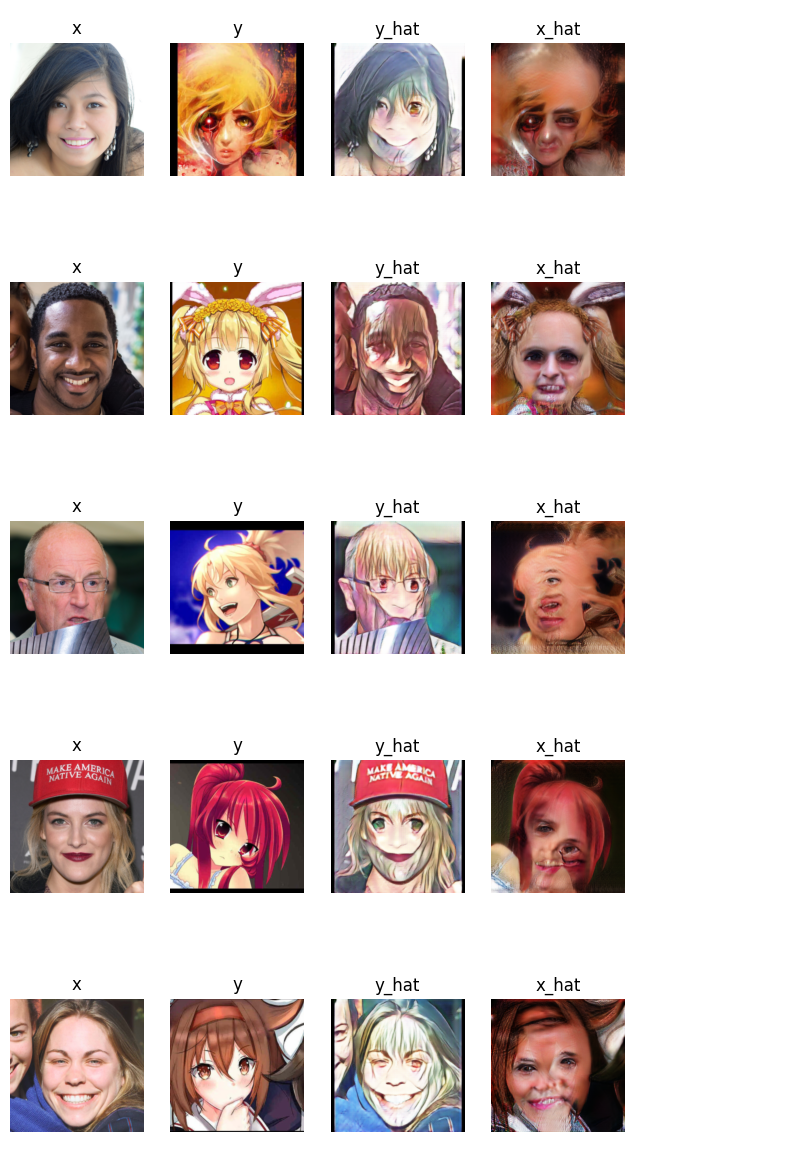

In [27]:
show_some_examples(cycle_gan, val_dataset)

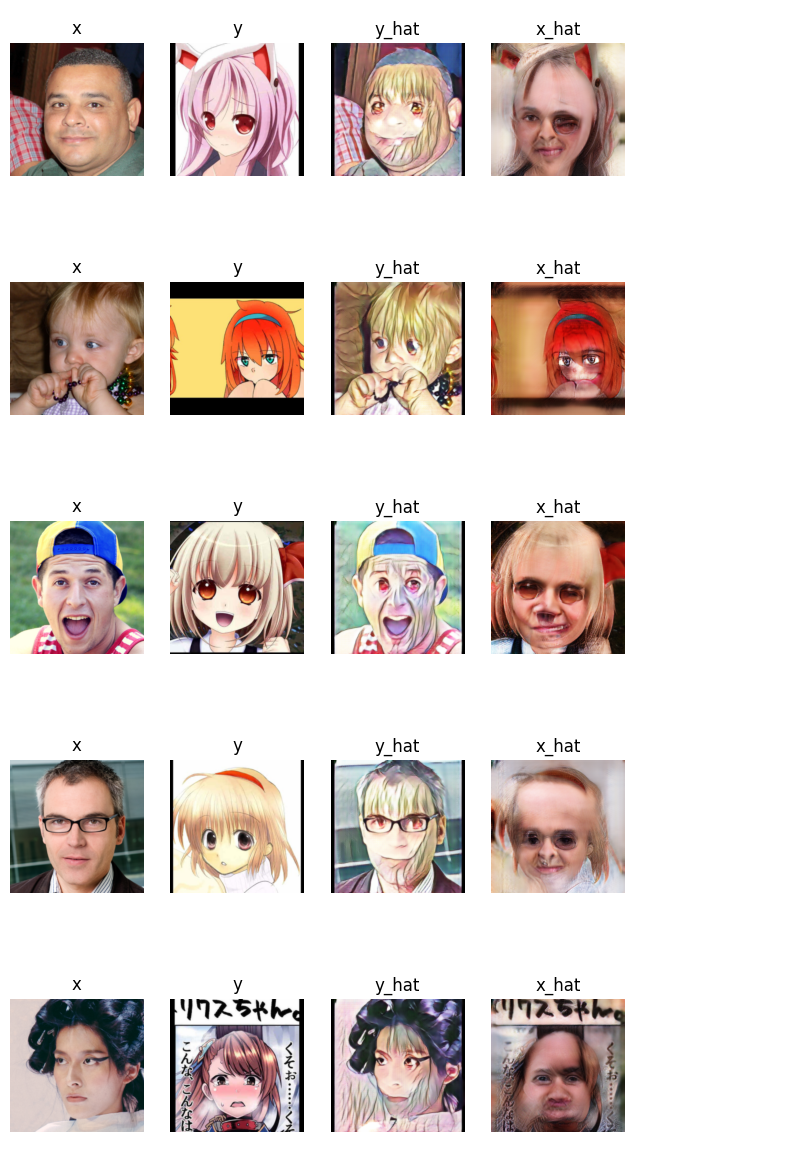

In [28]:
show_some_examples(cycle_gan, val_dataset)

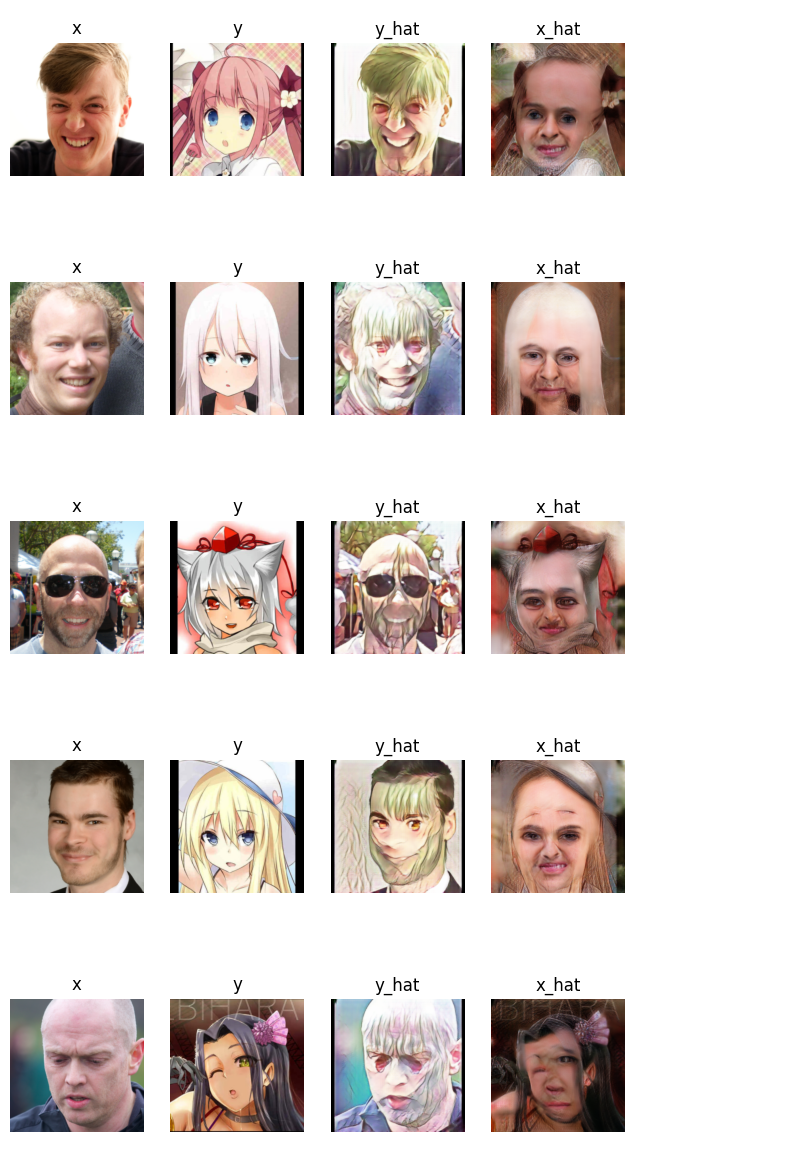

In [29]:
show_some_examples(cycle_gan, val_dataset)

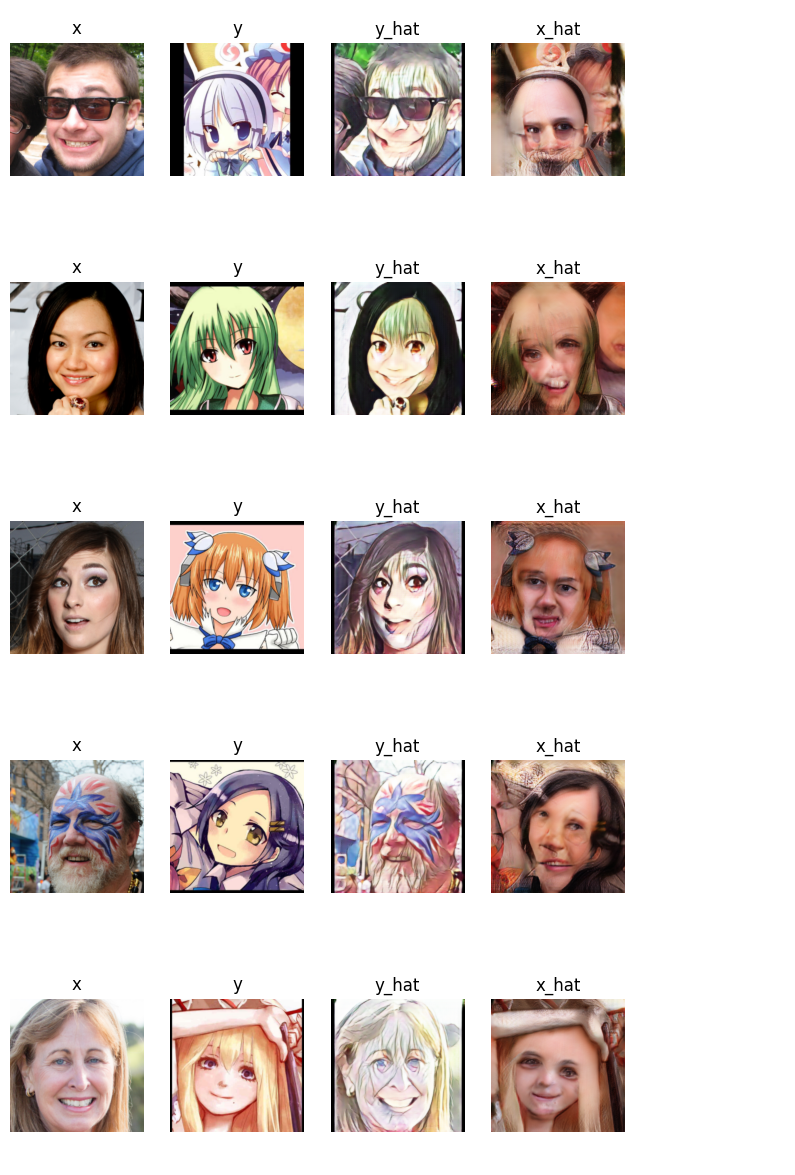

In [30]:
show_some_examples(cycle_gan, val_dataset)

### Train examples

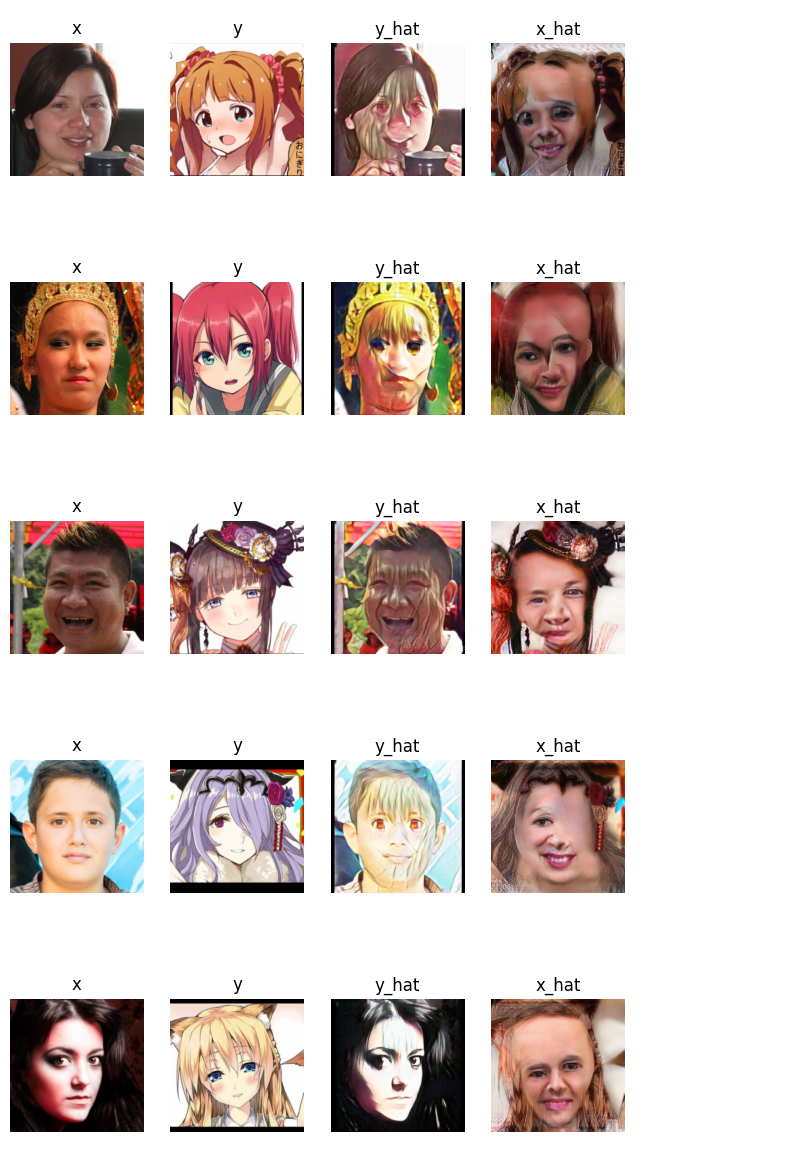

In [31]:
show_some_examples(cycle_gan, train_dataset)

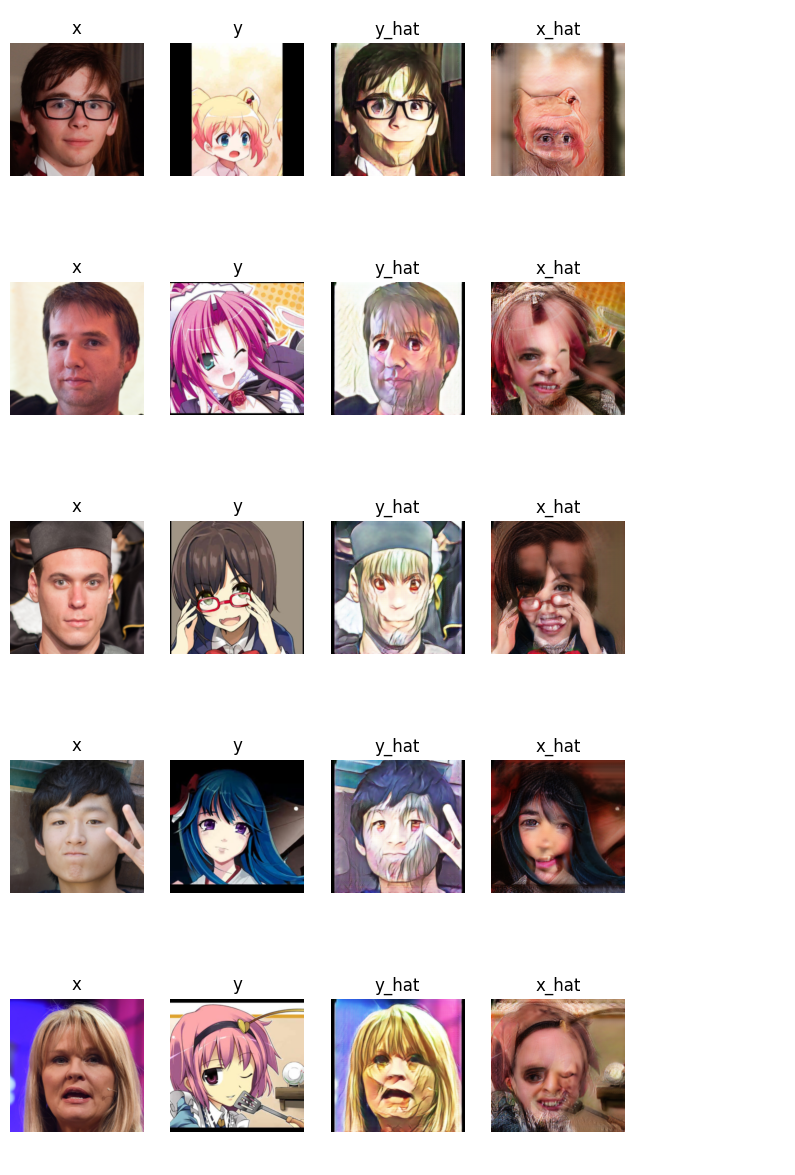

In [32]:
show_some_examples(cycle_gan, train_dataset)

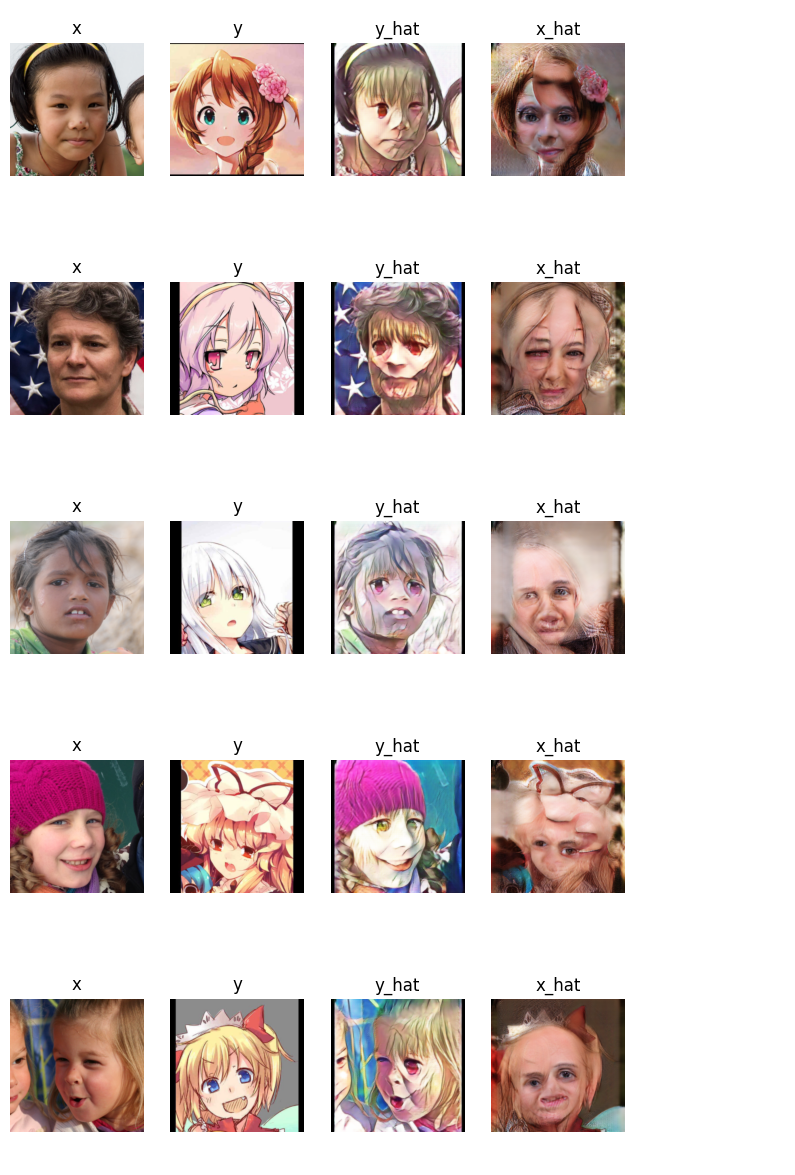

In [33]:
show_some_examples(cycle_gan, train_dataset)

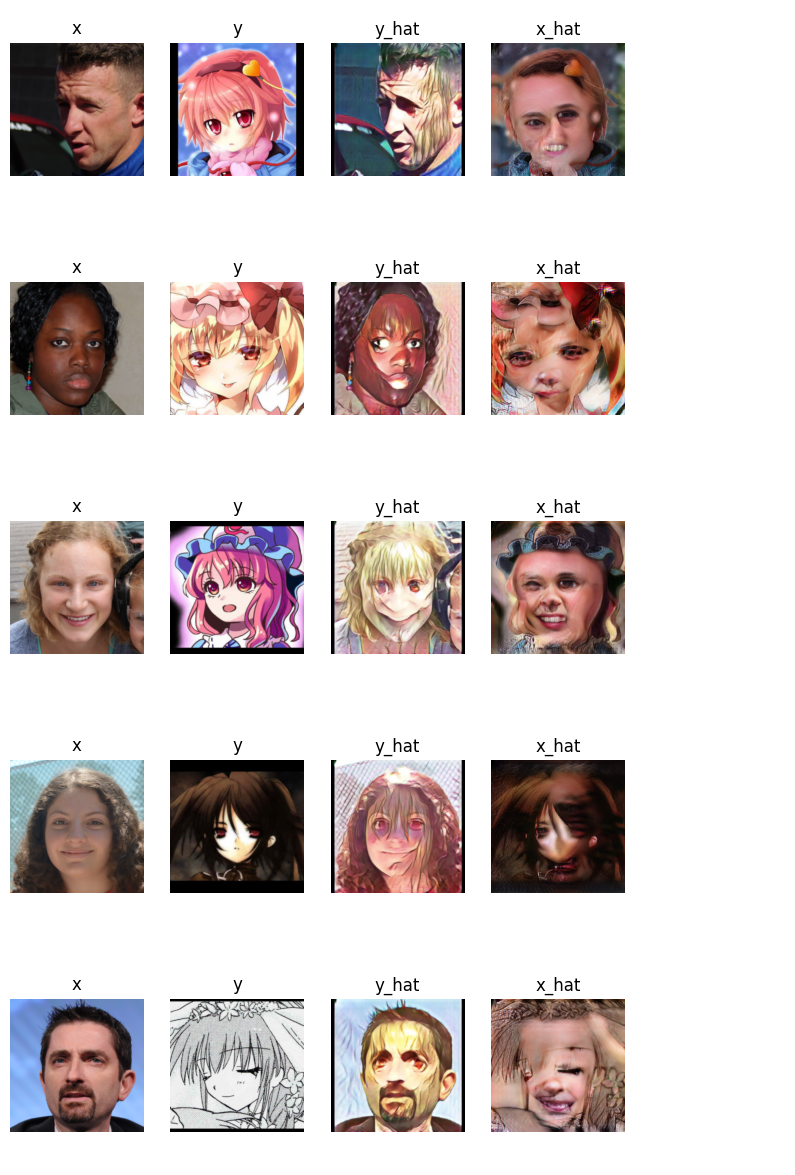

In [34]:
show_some_examples(cycle_gan, train_dataset)

# Overview

The current checkpoint was saved at epoch 158.
While the model is working, there is still minor mode collapse on some training examples.
We also observe several artifacts, such as excessive facial hair and incomplete transfer of anime-style faces onto human faces.